In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


import helper
import preprocessing


# Let's load the data and see what we have here

In [5]:
# Read payment data

pd_trans = pd.read_csv('transactions.csv')
# Read customer data

pd_customer = pd.read_csv('customers.csv')

In [6]:
pd_trans.head()

,id,over_due_1,over_due_2,over_due_3,over_due_total,pay_normal,prod_code,prod_limit,update_date,current_balance,highest_balance,last_payment_date
0,58987402,0,0,0,0,1,10,16500.0,4/12/16,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,4/12/16,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,4/12/16,840000.0,700500.0,22/4/16
3,54988608,0,0,0,0,3,10,37400.0,3/12/16,8425.2,7520.0,25/4/16
4,54987763,0,0,0,0,2,10,NaN,3/12/16,15147.6,NaN,26/4/16


In [7]:
pd_customer.head()

,label,id,demo_1,demo_2,demo_3,demo_4,demo_5,demo_6,demo_7,demo_8,demo_9,demo_10,demo_11
0,1,54982665,5,1245.5,3,77000,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000,2,11,5,108,4,450081,197.403141


___
*Looks great! We have a few columns with NaNs here and there. Let's see how bad it is*
___

# Health Check

## Payment

In [8]:
pd_trans.isna().any()

id                   False
over_due_1           False
over_due_2           False
over_due_3           False
over_due_total       False
pay_normal           False
prod_code            False
prod_limit            True
update_date           True
current_balance      False
highest_balance       True
last_payment_date     True
dtype: bool

### Prod_Limit

In [9]:
pd_trans.groupby(pd_trans['prod_limit'].isna()).prod_code.unique()

prod_limit
False                                             [10, 22]
True     [5, 10, 1, 0, 6, 13, 7, 24, 2, 19, 26, 9, 22, ...
Name: prod_code, dtype: object

---
*As we can see, only products of code 10 and 22 have product limit. So for those payment whose missing prod_limit that's associated with prod_code 10 and 22, we will retrieve the values from records whose prod_limit are not missing to fill in*
___


In [10]:
# Compute mean of prod_limit's mean according to id and prod_code

pd_trans[pd_trans['prod_code'].isin([10,22])].groupby(['prod_code']).agg({'prod_limit':'mean'})\
                    .reset_index().head(50)

,prod_code,prod_limit
0,10,85700.912764
1,22,275000.000000


In [11]:
# Let's have a look at highest balances of products 10 and 22

pd_trans[pd_trans['prod_code'].isin([10,22])].groupby(['prod_code']).agg({'highest_balance':'max'})\
                    .reset_index().sort_values('highest_balance',ascending=False).head(50)

,prod_code,highest_balance
0,10,902720.0
1,22,219256.0


---
*To fill in the missing values, we use the highest values of each label from either* **prod_limit's mean** or **highest_balance's max**

In [12]:
# Let's fill prod_code 10 and 22's NAs with max(prod_limit_mean, highest_balance) accordingly

pd_trans[pd_trans['prod_code'].isin([10]) & pd_trans['prod_limit'].isna()] = pd_trans[pd_trans['prod_code'].isin([10]) & pd_trans['prod_limit'].isna()].fillna(902720.0)
pd_trans[pd_trans['prod_code'].isin([22]) & pd_trans['prod_limit'].isna()] = pd_trans[pd_trans['prod_code'].isin([22]) & pd_trans['prod_limit'].isna()].fillna(275000.0)

In [13]:
pd_trans.groupby(pd_trans['prod_limit'].isna()).prod_code.unique()

prod_limit
False                                             [10, 22]
True     [5, 1, 0, 6, 13, 7, 24, 2, 19, 26, 9, 3, 8, 15...
Name: prod_code, dtype: object

*So no more NAs for prod_code 10 and 22*
___
*For other prod_codes, we simply take their maximum highest_balance and fill in respectively*

In [14]:
# Compute max highest_balance of each customer

pd_max_highest_balance = pd_trans.groupby('id').highest_balance.max().reset_index()\
                                .rename(columns={'highest_balance':'max_highest_balance'})

In [15]:
pd_merged_temp = pd_trans.merge(pd_max_highest_balance, on = 'id', how = 'left')

pd_trans['prod_limit'] = pd_merged_temp['prod_limit'].fillna(pd_merged_temp['max_highest_balance'])

In [16]:
pd_trans.groupby(pd_trans['prod_limit'].isna()).prod_code.unique()

prod_limit
False    [10, 5, 1, 0, 6, 13, 7, 24, 2, 19, 26, 9, 22, ...
Name: prod_code, dtype: object

*Cool, no more NAs on prod_limit*
___

## update_date and last_payment_date

In [17]:
pd_trans[['id','update_date','last_payment_date','current_balance','over_due_1','over_due_2','over_due_3']]\
        [~pd_trans['last_payment_date'].isna()].sort_values('id')\
        .head(10)

,id,update_date,last_payment_date,current_balance,over_due_1,over_due_2,over_due_3
8041,54982353,17/9/03,28/3/06,0.0,0,0,0
7749,54982353,30/9/05,902720,0.0,0,0,0
7234,54982353,12/3/07,902720,0.0,0,0,0
7878,54982353,16/2/05,18/1/08,0.0,0,0,0
8035,54982353,17/10/03,28/5/05,0.0,0,0,0
8200,54982353,21/4/97,21/7/15,-1197.6,1,0,0
6215,54982353,27/12/08,14/7/09,12142.8,0,0,35
7233,54982353,12/3/07,23/12/15,252998.4,0,0,0
7235,54982353,12/3/07,21/5/11,120381.6,0,0,0
7838,54982353,22/4/05,7/10/05,0.0,1,2,3


*Since the problem (credit risk assestment) less likely to have anything to do with seasonality, let's do a simply transformation to convert dates to numerical. Here we use the number of days since 1970/1/1*

In [18]:
'''
Convert dates to "number of days". The number of days will be counted from 1970/1/1
'''
def reformat_date(x):
    import datetime
    # Initialize empty year, month and day
    year = None
    month = None
    day = None
    
    # Initialize base date
    base = datetime.datetime(1970,1,1)
    
    x = str(x)
    
    # Initialize empty date
    date = None
    try:
        #If the date string follows the YY/mm/dd format
        if '/' in x:
            elems = x.split('/')

            # Process year
            if len(elems[2]) == 4:
                year = int(elems[2])
            elif int(elems[2]) > 70:
                # This means the year is before 2000
                year = int('19' + elems[2])
            else:
                year = int('20' + elems[2])

            month = int(elems[1])
            day = int(elems[0])
        else:
            # In this case, the date seems tobe entered in YYmmdd format
            year = x[:2]
            if int(year) > 70:
                year = int('19' + year)
            else:
                year = int('20' + year)

            if len(x) == 6:
                month = int(x[2:4])
                day = int(x[4:6])
            elif len(x) == 5:
                # We assume this's the case when month is from Jan to Sep.
                month = int(x[2:3])
                day = int(x[3:5])


        date = datetime.datetime(year,month,day)
        return (date - base).days
    except Exception as e:
        return None
    
    
# Convert dates to number of days since 1970/1/1
pd_trans['update_date'] = [reformat_date(x) for x in pd_trans['update_date'].tolist()]
pd_trans['last_payment_date'] = [reformat_date(x) for x in pd_trans['last_payment_date'].tolist()]


# Convert number of days to number of day until "today". 
# In reality, the prediction should be made in almost real time on the latest data. In that case, formating 
# dates as number of prior days won't make sense since new data will come from a different distribution anyway.
max_date = np.max(pd_trans[['update_date','last_payment_date']]) + 1
pd_trans[['update_date','last_payment_date']] = max_date - pd_trans[['update_date','last_payment_date']]

In [19]:
pd_trans.head()

,id,over_due_1,over_due_2,over_due_3,over_due_total,pay_normal,prod_code,prod_limit,update_date,current_balance,highest_balance,last_payment_date
0,58987402,0,0,0,0,1,10,16500.0,1.0,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,491100.0,1.0,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,4225500.0,1.0,840000.0,700500.0,229.0
3,54988608,0,0,0,0,3,10,37400.0,2.0,8425.2,7520.0,226.0
4,54987763,0,0,0,0,2,10,902720.0,2.0,15147.6,902720.0,225.0


In [20]:
# Fill NAs for update_date and report_date with the latest dates respectively

pd_trans['update_date'] = pd_trans['update_date'].fillna(np.nanmax(pd_trans['update_date']))
pd_trans['last_payment_date'] = pd_trans['last_payment_date'].fillna(np.nanmax(pd_trans['last_payment_date']))

In [21]:
# Fill NAs for highest_balance by the maximum current_balance respectively to each customer

pd_max_new_balance = pd_trans.groupby('id').agg({'current_balance':'max'}).reset_index()\
                        .rename(columns = {'current_balance':'max_current_balance'})

pd_merge_temp = pd_trans.merge(pd_max_new_balance, on = 'id', how = 'left')
pd_trans['highest_balance'] = pd_trans['highest_balance'].fillna(pd_merge_temp['max_current_balance'])

In [22]:
pd_trans.isna().any()

id                   False
over_due_1           False
over_due_2           False
over_due_3           False
over_due_total       False
pay_normal           False
prod_code            False
prod_limit           False
update_date          False
current_balance      False
highest_balance      False
last_payment_date    False
dtype: bool

## Customer

**Let's see if we have any missing values**

In [23]:
pd_customer.isna().any()

label      False
id         False
demo_1     False
demo_2      True
demo_3     False
demo_4     False
demo_5     False
demo_6     False
demo_7     False
demo_8     False
demo_9     False
demo_10    False
demo_11    False
dtype: bool

---
Only demo_2 displays some NAs, the rest is pretty clean. 

Since demo_2 is a numerical feature, let's use KNN regression to fill in this data

In [24]:
pd_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 13 columns):
label      1125 non-null int64
id         1125 non-null int64
demo_1     1125 non-null int64
demo_2     976 non-null float64
demo_3     1125 non-null int64
demo_4     1125 non-null int64
demo_5     1125 non-null int64
demo_6     1125 non-null int64
demo_7     1125 non-null int64
demo_8     1125 non-null int64
demo_9     1125 non-null int64
demo_10    1125 non-null int64
demo_11    1125 non-null float64
dtypes: float64(2), int64(11)
memory usage: 114.3 KB


In [25]:
pd_customer = preprocessing.Imputor.knnRegressor(pd_customer, 
                                                 'demo_2', 
                                                 predictors= ['id','demo_1','demo_3','demo_4','demo_5','demo_6','demo_7','demo_8','demo_9','demo_10','demo_11'])

preprocessing.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_w_NAs[target] = model.predict(X_w_NAs[predictors])


In [26]:
pd_customer.isna().any()

label      False
id         False
demo_1     False
demo_2     False
demo_3     False
demo_4     False
demo_5     False
demo_6     False
demo_7     False
demo_8     False
demo_9     False
demo_10    False
demo_11    False
dtype: bool

In [27]:
pd_customer.nunique()

label         2
id         1125
demo_1        6
demo_2      307
demo_3        3
demo_4      229
demo_5        2
demo_6       10
demo_7       10
demo_8       52
demo_9        5
demo_10     280
demo_11     266
dtype: int64

# One-hot transformation on categorical features

## Customer data

In [28]:
cat_feas = ['demo_1','demo_3','demo_5','demo_6','demo_7','demo_9']

for col in cat_feas:
    pd_customer[col] = pd_customer[col].astype('category')

In [29]:
pd_customer = pd.get_dummies(pd_customer, prefix = cat_feas).groupby('id').sum().sort_values('id')

## Payment data

In [30]:
pd_trans['prod_code'] = pd_trans.prod_code.astype('category')

In [31]:
pd_trans['highest_balance'] = pd_trans.highest_balance.astype('float32')
pd_trans['update_date'] = pd_trans.update_date.astype('float32')
pd_trans['last_payment_date'] = pd_trans.last_payment_date.astype('float32')

In [32]:
pd_trans = pd.get_dummies(pd_trans, prefix=['prod_code'])

In [33]:
pd_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8250 entries, 0 to 8249
Data columns (total 32 columns):
id                   8250 non-null int64
over_due_1           8250 non-null int64
over_due_2           8250 non-null int64
over_due_3           8250 non-null int64
over_due_total       8250 non-null int64
pay_normal           8250 non-null int64
prod_limit           8250 non-null float64
update_date          8250 non-null float32
current_balance      8250 non-null float64
highest_balance      8250 non-null float32
last_payment_date    8250 non-null float32
prod_code_0          8250 non-null uint8
prod_code_1          8250 non-null uint8
prod_code_2          8250 non-null uint8
prod_code_3          8250 non-null uint8
prod_code_4          8250 non-null uint8
prod_code_5          8250 non-null uint8
prod_code_6          8250 non-null uint8
prod_code_7          8250 non-null uint8
prod_code_8          8250 non-null uint8
prod_code_9          8250 non-null uint8
prod_code_10         8

In [34]:
agg = {'prod_limit':'max',
       'update_date':'max',
       'current_balance':['sum','max','mean'],
       'highest_balance':['max','mean'],
       'last_payment_date':'max'}

for col in pd_trans.columns:
    if (col not in agg) and (col not in ['id']):
        agg[col] = 'sum'

pd_trans = pd_trans.groupby('id').agg(agg).reset_index()

In [35]:
pd_trans.columns = ['_'.join(col).strip() for col in pd_trans.columns.values]
pd_trans.rename(columns={'id_':'id'},inplace=True)

In [36]:
pd_trans.head()

,id,over_due_total_sum,prod_code_25_sum,over_due_2_sum,over_due_3_sum,over_due_1_sum,prod_code_26_sum,update_date_max,prod_code_24_sum,last_payment_date_max,prod_code_22_sum,prod_limit_max,pay_normal_sum,highest_balance_max,highest_balance_mean,prod_code_27_sum,prod_code_7_sum,prod_code_6_sum,prod_code_5_sum,prod_code_4_sum,prod_code_3_sum,prod_code_2_sum,prod_code_1_sum,prod_code_0_sum,prod_code_9_sum,prod_code_8_sum,prod_code_19_sum,prod_code_13_sum,current_balance_sum,current_balance_max,current_balance_mean,prod_code_10_sum,prod_code_17_sum,prod_code_15_sum,prod_code_12_sum
0,54982353,32078,0,2,38,3,0,8023.0,0,7592.0,0,902720.0,229,902720.0,392391.78125,0,0,0,0,0,0,1,1,0,0,0,0,0,756596.4,326684.4,42033.133333,16,0,0,0
1,54982356,0,0,0,0,0,0,6746.0,0,7592.0,0,902720.0,117,600500.0,196649.28125,2,0,2,0,0,0,0,0,0,0,0,0,0,15944.4,15938.4,2277.771429,2,0,0,1
2,54982387,12,0,0,0,3,0,4828.0,0,1946.0,0,1200500.0,246,1200500.0,238270.00000,0,0,4,0,0,0,0,3,0,0,0,0,0,1292006.4,917833.2,117455.127273,4,0,0,0
3,54982463,0,0,0,0,0,0,1774.0,0,1230.0,0,100500.0,34,100500.0,78500.00000,0,0,0,1,0,0,0,0,0,0,0,0,1,79780.8,79780.8,39890.400000,0,0,0,0
4,54982530,0,0,0,0,0,0,1097.0,0,509.0,0,902720.0,56,24117.0,12787.75000,0,0,0,0,0,0,0,0,0,0,0,0,0,5044.8,4371.6,1261.200000,4,0,0,0


In [37]:
'''
Normalize over_due_2_sum, over_due_3_sum, over_due_1_sum and pay_normal_sum by
no_of_payments_sum
'''

# for col in ['over_due_2_sum', 'over_due_3_sum', 'over_due_1_sum','pay_normal_sum']:
#     pd_payment[col] = pd_payment[col] / pd_payment['no_of_payments_sum']

'\nNormalize over_due_2_sum, over_due_3_sum, over_due_1_sum and pay_normal_sum by\nno_of_payments_sum\n'

In [38]:
pd_trans.sort_values('over_due_total_sum', ascending=False).head(20)

,id,over_due_total_sum,prod_code_25_sum,over_due_2_sum,over_due_3_sum,over_due_1_sum,prod_code_26_sum,update_date_max,prod_code_24_sum,last_payment_date_max,prod_code_22_sum,prod_limit_max,pay_normal_sum,highest_balance_max,highest_balance_mean,prod_code_27_sum,prod_code_7_sum,prod_code_6_sum,prod_code_5_sum,prod_code_4_sum,prod_code_3_sum,prod_code_2_sum,prod_code_1_sum,prod_code_0_sum,prod_code_9_sum,prod_code_8_sum,prod_code_19_sum,prod_code_13_sum,current_balance_sum,current_balance_max,current_balance_mean,prod_code_10_sum,prod_code_17_sum,prod_code_15_sum,prod_code_12_sum
78,54984903,81050,0,3,114,1,0,3646.0,1,7592.0,0,902720.0,46,290500.0,96053.398438,0,0,0,1,0,0,0,0,0,0,0,0,0,352411.2,269202.0,35241.120000,7,0,0,1
270,54989873,76200,0,2,88,0,0,3258.0,0,3059.0,0,902720.0,38,100500.0,75615.664062,0,0,0,2,0,0,0,0,0,0,0,0,0,85466.4,85466.4,14244.400000,4,0,0,0
604,58990934,70510,0,27,115,28,0,4024.0,0,7592.0,0,902720.0,128,902720.0,161703.203125,0,0,0,4,0,0,0,0,0,0,0,0,1,195663.6,104979.6,13044.240000,10,0,0,0
392,58984653,69435,0,3,103,4,0,3489.0,0,2833.0,0,1500500.0,46,1500500.0,271295.437500,0,0,0,2,0,0,1,0,0,0,0,0,0,2068850.4,1968345.6,295550.057143,4,0,0,0
731,58994346,67891,0,21,153,15,0,3985.0,0,7592.0,0,1797797.0,278,1797797.0,303929.718750,0,0,1,3,0,0,2,1,1,0,0,0,0,2764040.4,1649192.4,120175.669565,15,0,0,0
457,58986716,49784,0,6,78,68,0,10366.0,0,7592.0,0,902720.0,99,902720.0,250368.921875,0,0,2,4,0,0,0,4,0,0,0,0,0,278018.4,152637.6,15445.466667,8,0,0,0
688,58993212,49353,0,12,105,13,0,4454.0,0,7592.0,0,902720.0,288,902720.0,95184.906250,0,7,1,4,0,0,0,0,1,0,0,0,2,304650.0,182515.2,10155.000000,13,0,2,0
704,58993744,42279,0,2,48,5,0,4501.0,0,7592.0,0,4108152.0,247,4836636.0,928103.437500,0,0,1,4,0,1,1,3,0,0,0,0,2,5376894.0,4836636.0,282994.421053,7,0,0,0
723,58994149,37259,0,11,102,13,0,3979.0,0,7592.0,0,902720.0,214,438110.0,157368.296875,0,5,1,2,0,0,0,0,0,0,0,0,0,391507.2,259080.0,23029.835294,9,0,0,0
664,58992450,36299,0,6,61,5,0,3591.0,0,7592.0,0,902720.0,78,70500.0,40745.714844,0,0,0,3,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,4,0,0,0


(array([53., 36., 42., 13., 14., 10.,  7.,  6.,  7.,  1.,  8.,  8.,  4.,
         4.,  5.,  2.,  1.,  3.,  1.,  3.,  3.,  3.,  2.,  1.,  2.,  1.,
         1.,  2.,  1.,  4.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  0.,  4.,
         2.,  1.,  0.,  2.,  0.,  1.,  2.,  1.,  2.,  0.,  2.,  1.,  3.,
         3.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  2.,  1.,
         1.,  0.,  0.,  3.,  3.,  1.,  0.,  1.,  1.,  1.,  2.,  3.,  3.,
         1.,  1.,  0.,  1.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([   1.  ,   10.99,   20.98,   30.97,   40.96,   50.95,   60.94,
          70.93,   80.92,   90.91,  100.9 ,  110.89,  120.88,  130.87,
         140.86,  150.85,  160.84,  170.83,  180.82,  190.81,  200.8 ,
         210.79,  220.78,  230.77,  240.76,  250.75,  260.74,  270.73,
         280.72,  290.71,  300.7 ,  310.69,  320.68,  330.67,  340.66,
         350.65,  360.64,  370.63,  380.62,  390.61,  400.6 ,  410.59,
        

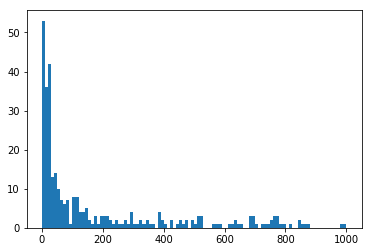

In [39]:
plt.hist(pd_trans['over_due_total_sum'], bins=100, range=(1,1000))

# Join

In [40]:
# Join data to make credit data

pd_credit = pd_customer.merge(pd_trans,on = ['id'], how='left')

In [41]:
pd_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1125 entries, 0 to 1124
Data columns (total 77 columns):
id                       1125 non-null int64
label                    1125 non-null int64
demo_2                   1125 non-null float64
demo_4                   1125 non-null int64
demo_8                   1125 non-null int64
demo_10                  1125 non-null int64
demo_11                  1125 non-null float64
demo_1_1                 1125 non-null uint8
demo_1_2                 1125 non-null uint8
demo_1_4                 1125 non-null uint8
demo_1_5                 1125 non-null uint8
demo_1_6                 1125 non-null uint8
demo_1_7                 1125 non-null uint8
demo_3_1                 1125 non-null uint8
demo_3_2                 1125 non-null uint8
demo_3_3                 1125 non-null uint8
demo_5_1                 1125 non-null uint8
demo_5_2                 1125 non-null uint8
demo_6_3                 1125 non-null uint8
demo_6_4                 1125 non-

In [42]:
pd_credit.head()

,id,label,demo_2,demo_4,demo_8,demo_10,demo_11,demo_1_1,demo_1_2,demo_1_4,demo_1_5,demo_1_6,demo_1_7,demo_3_1,demo_3_2,demo_3_3,demo_5_1,demo_5_2,demo_6_3,demo_6_4,demo_6_5,demo_6_6,demo_6_8,demo_6_9,demo_6_11,demo_6_12,demo_6_15,demo_6_16,demo_7_-1,demo_7_1,demo_7_2,demo_7_3,demo_7_4,demo_7_5,demo_7_7,demo_7_8,demo_7_9,demo_7_10,demo_9_1,demo_9_2,demo_9_3,demo_9_4,demo_9_5,over_due_total_sum,prod_code_25_sum,over_due_2_sum,over_due_3_sum,over_due_1_sum,prod_code_26_sum,update_date_max,prod_code_24_sum,last_payment_date_max,prod_code_22_sum,prod_limit_max,pay_normal_sum,highest_balance_max,highest_balance_mean,prod_code_27_sum,prod_code_7_sum,prod_code_6_sum,prod_code_5_sum,prod_code_4_sum,prod_code_3_sum,prod_code_2_sum,prod_code_1_sum,prod_code_0_sum,prod_code_9_sum,prod_code_8_sum,prod_code_19_sum,prod_code_13_sum,current_balance_sum,current_balance_max,current_balance_mean,prod_code_10_sum,prod_code_17_sum,prod_code_15_sum,prod_code_12_sum
0,54982353,0,1130.0,1000000,100,650018,1.000000,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,32078,0,2,38,3,0,8023.0,0,7592.0,0,902720.0,229,902720.0,392391.78125,0,0,0,0,0,0,1,1,0,0,0,0,0,756596.4,326684.4,42033.133333,16,0,0,0
1,54982356,0,1391.0,1200000,64,361026,1.000000,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6746.0,0,7592.0,0,902720.0,117,600500.0,196649.28125,2,0,2,0,0,0,0,0,0,0,0,0,0,15944.4,15938.4,2277.771429,2,0,0,1
2,54982387,1,1349.0,286000,80,361003,1.000000,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,3,0,4828.0,0,1946.0,0,1200500.0,246,1200500.0,238270.00000,0,0,4,0,0,0,0,3,0,0,0,0,0,1292006.4,917833.2,117455.127273,4,0,0,0
3,54982463,0,1272.5,70000,113,60033,167.122709,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1774.0,0,1230.0,0,100500.0,34,100500.0,78500.00000,0,0,0,1,0,0,0,0,0,0,0,0,1,79780.8,79780.8,39890.400000,0,0,0,0
4,54982530,0,1272.5,120000,110,72000,187.082869,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1097.0,0,509.0,0,902720.0,56,24117.0,12787.75000,0,0,0,0,0,0,0,0,0,0,0,0,0,5044.8,4371.6,1261.200000,4,0,0,0


In [43]:
# # Aggregate data by id
# pd_credit = pd_credit.groupby(['id','label']).agg({x:['sum'] for x in pd_credit.columns if x not in ['id','label']}).reset_index()

# pd_credit.columns = [' '.join(col).strip() for col in pd_credit.columns.values]

In [44]:
pd_credit.isna().any()

id                       False
label                    False
demo_2                   False
demo_4                   False
demo_8                   False
demo_10                  False
demo_11                  False
demo_1_1                 False
demo_1_2                 False
demo_1_4                 False
demo_1_5                 False
demo_1_6                 False
demo_1_7                 False
demo_3_1                 False
demo_3_2                 False
demo_3_3                 False
demo_5_1                 False
demo_5_2                 False
demo_6_3                 False
demo_6_4                 False
demo_6_5                 False
demo_6_6                 False
demo_6_8                 False
demo_6_9                 False
demo_6_11                False
demo_6_12                False
demo_6_15                False
demo_6_16                False
demo_7_-1                False
demo_7_1                 False
                         ...  
over_due_1_sum           False
prod_cod

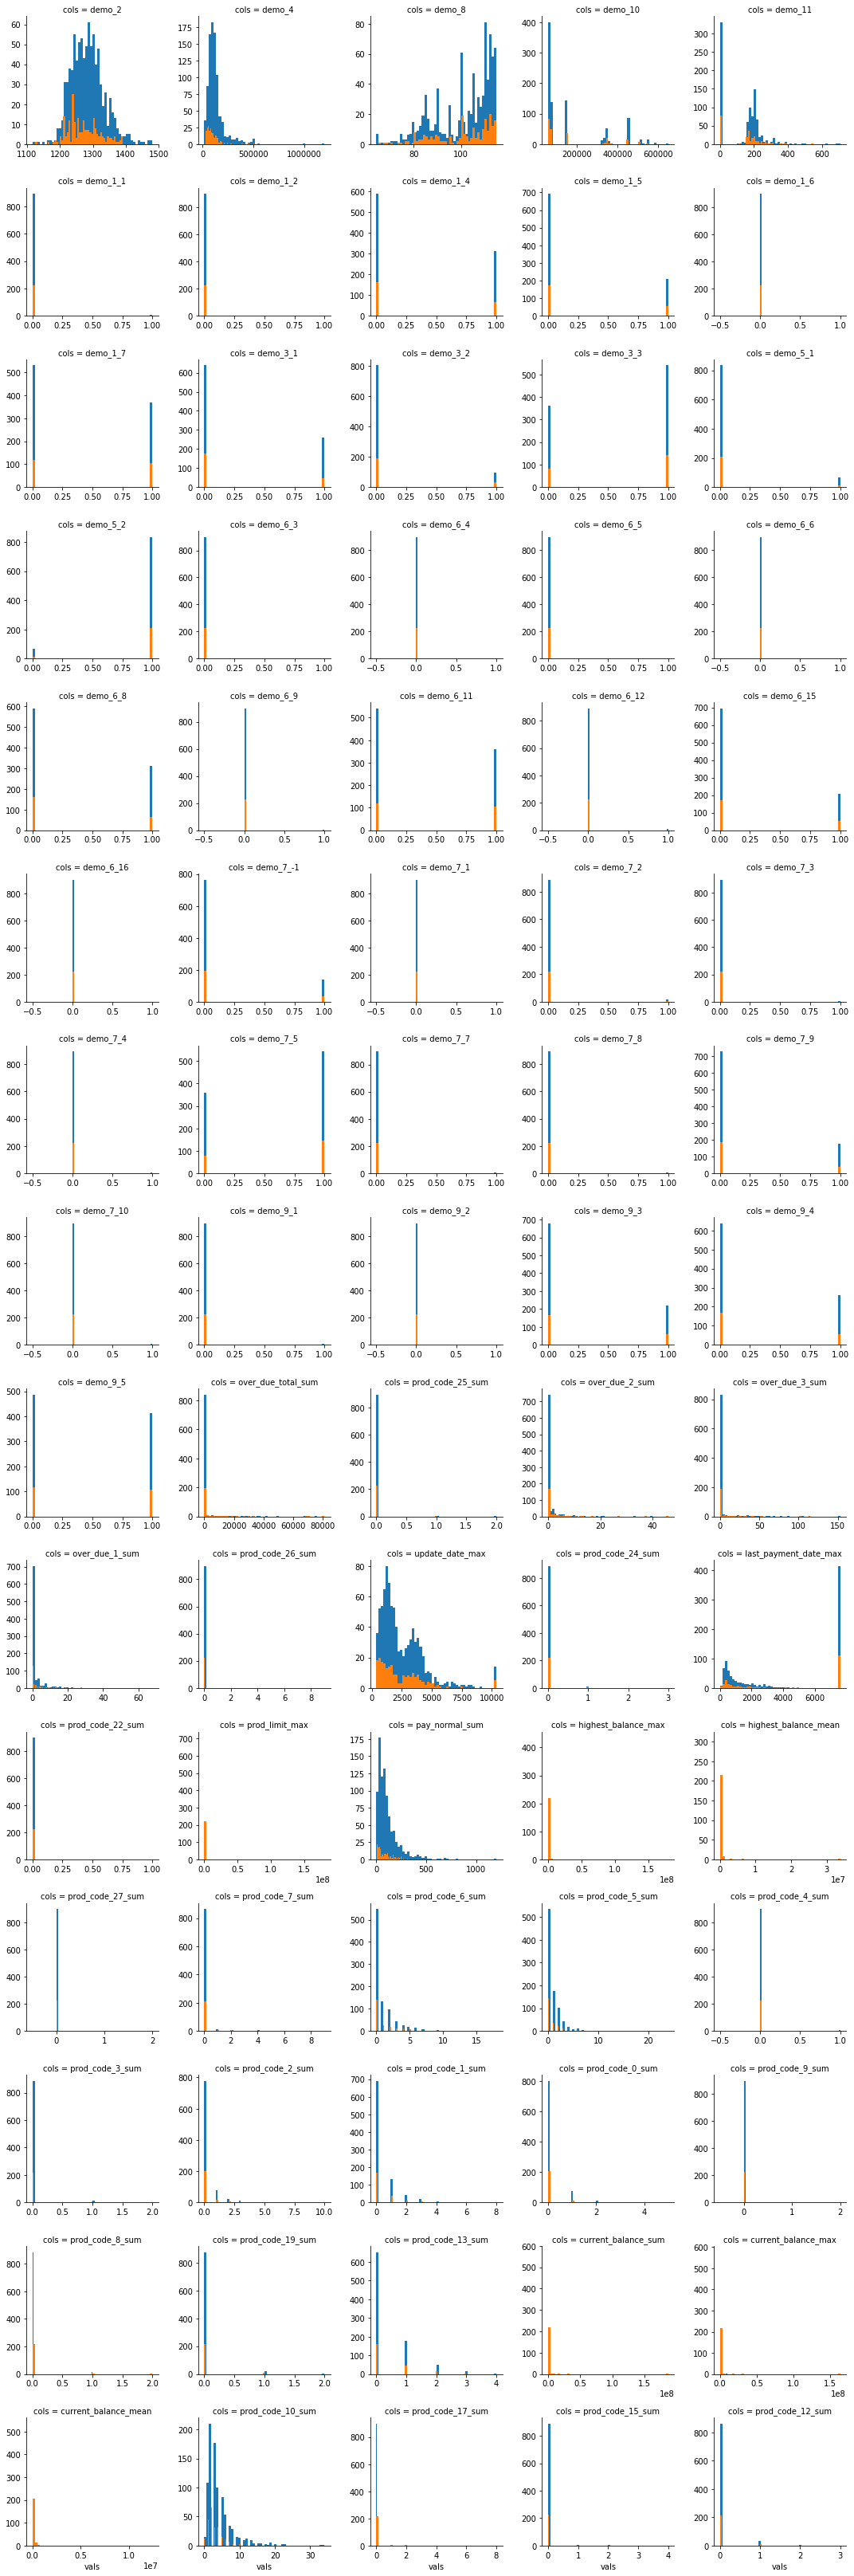

In [45]:
helper.plotHistNumerical(pd_credit, [col for col in pd_credit.columns if col not in ['id','label']], hue = 'label')

In [46]:
num_cols = [col for col in pd_credit.columns if col not in ['id','label']]

/Users/tungpt/miniconda3/envs/python2/lib/python2.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


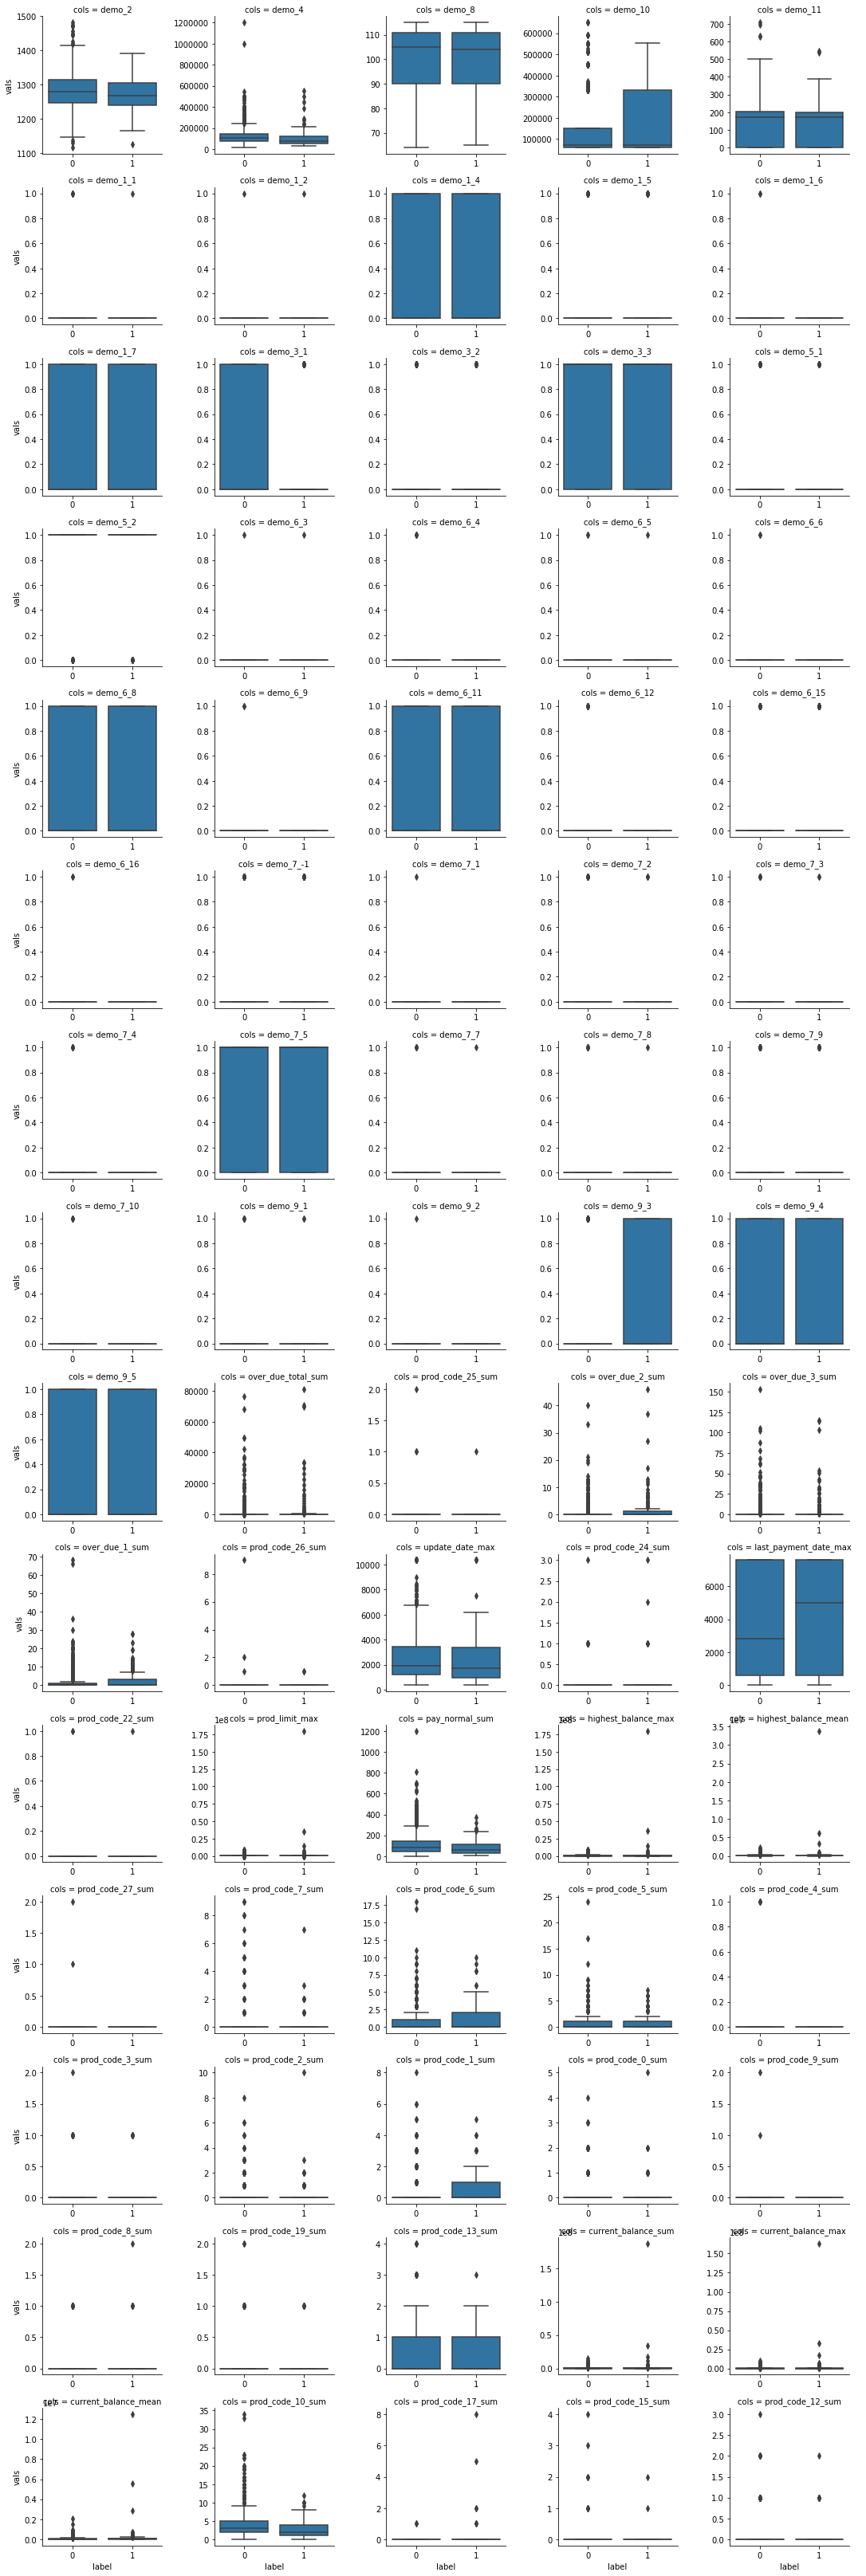

In [47]:
helper.plotBoxPlot(pd_credit, num_cols, label = 'label')

# Training

In [48]:
# Examining data's label distribution

pd_credit.groupby('label').size()


label
0    900
1    225
dtype: int64

In [49]:
def splitTrainTest(data, train_portion = 0.8, seed = 0):
    import numpy as np
    np.random.seed(seed)
    if train_portion < 1:
        mask = np.random.rand(len(data)) < train_portion
        train = data[mask]
        test = data[~mask]
    else:
        mask = np.random.rand(len(data)) * len(data) < train_portion
        train = data[mask]
        test = data[~mask]
    
    return train, test

In [50]:
seed = 5

In [51]:
a = set([1,2,3,3])

for x in a:
    print(x)

1
2
3


In [52]:
# Split data by 80/20
print("Seed: " + str(seed))

inp = pd_credit

# train_pos, test_pos = splitTrainTest(inp[inp['label'] == 1], seed=55)
# test_size = len(test_pos)

# train_neg, test_neg = splitTrainTest(inp[inp['label'] == 0], 
#                                      len(inp[inp['label'] == 0]) - test_size, seed = 55)

# train = pd.concat([train_pos,train_neg], axis=0)
# test = pd.concat([test_pos, test_neg], axis=0)

train, test = helper.splitTrainTest(inp, train_proportion=0.8, target = 'label', balance_test_set=True, seed = 55)

seed += 5

Seed: 5


In [53]:
features = [col for col in pd_credit.columns if col not in ['id','label']]

normalizer = preprocessing.Normalizer()

train = normalizer.fit_transform(train, features)
test = normalizer.transform(test,features)

In [54]:
train.groupby('label').size()

label
0    865
1    187
dtype: int64

In [55]:
features = np.array([x for x in train.columns if x not in ['id','label']])

In [56]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


# features = [x for x in train.columns if x not in ['id','label']]



parameters = {'booster':['gblinear','gbtree'],
                      'objective':['binary:logistic'],
                      'nthread':[6],
                      'silent': [False],
                      'subsample': [0.8],
                      'n_estimators': [25,50,100,150],
                      'max_depth': [1, 3, 5],
                      'lambda':[0.1, 1, 3],
                      'alpha':[0.1, 0.01, 0.001],
                      'learning_rate': [0.01, 0.1, 0.05]}


classifier = XGBClassifier(scale_pos_weight=4.55, eval_metric='logloss')

clf = GridSearchCV(classifier, parameters, n_jobs=6, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True), 
                           scoring='recall')


clf.fit(train[features],train['label'])

/Users/tungpt/miniconda3/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='logloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=4.55, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'n_estimators': [25, 50, 100, 150], 'subsample': [0.8], 'silent': [False], 'alpha': [0.1, 0.01, 0.001], 'objective': ['binary:logistic'], 'max_depth': [1, 3, 5], 'learning_rate': [0.01, 0.1, 0.05], 'lambda': [0.1, 1, 3], 'nthread': [6], 'booster': ['gblinear', 'gbtree']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0

In [57]:
clf.best_params_

{'alpha': 0.1,
 'booster': 'gbtree',
 'lambda': 0.1,
 'learning_rate': 0.05,
 'max_depth': 1,
 'n_estimators': 150,
 'nthread': 6,
 'objective': 'binary:logistic',
 'silent': False,
 'subsample': 0.8}

In [58]:
clf.best_score_

0.604737166624299

In [59]:
pred = clf.predict(test[features])

In [60]:
# Accuracy
from sklearn.metrics import *

accuracy_score(test['label'],pred)


0.7671232876712328

In [61]:
# Recall


recall_score(test['label'],pred)

0.7105263157894737

In [62]:
precision_score(test['label'],pred)

0.8181818181818182

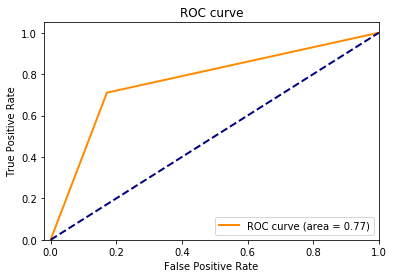

In [63]:
helper.plotROC_AUC(test['label'],pred)